In [1]:
import random
import time
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch import optim
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


'''Load data'''
lines = open('./train.txt', encoding='utf-8').read().strip().split('\n')
tense=['sp','tp','pg','past']
input_list=[]
target_list=[]
for line in lines:
    input_list.append(line.split(' ')[0])
    target_list.append(line.split(' '))
# print(input_list)
# print(target_list)

en_idx=['sos','eos','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u'
        ,'v','w','x','y','z']


max_len=(15*4)+2
input_tensors=torch.ones(len(input_list),max_len, device=device,dtype=int)
target_tensors=torch.ones(len(target_list),max_len,1, device=device,dtype=int)
input_tensors[:,0]=0
target_tensors[:,0]=0
cnt1=0
for w in input_list:
    cnt2=28
    for i in range(1,max_len-1,15):
        input_tensors[cnt1,i-1]=0
        for j in range(len(w)):
            input_tensors[cnt1,i+j]=en_idx.index(w[j])
        input_tensors[cnt1,i+len(w)]=cnt2
        cnt2+=1 
    cnt1+=1
    
target_tensors[:,15]=0
target_tensors[:,30]=0
target_tensors[:,45]=0
cnt1=0
for words in target_list:
    for i in range(15):
        if i<len(words[0]):
            target_tensors[cnt1,1+i]=en_idx.index(words[0][i])
        if i<len(words[1]):
            target_tensors[cnt1,16+i]=en_idx.index(words[1][i])
        if i<len(words[2]):
            target_tensors[cnt1,31+i]=en_idx.index(words[2][i])
        if i<len(words[3]):
            target_tensors[cnt1,46+i]=en_idx.index(words[3][i])
    cnt1+=1

print(input_tensors[1],target_tensors[1])   

tensor([ 0,  2,  3,  6, 21, 28,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  2,  3,
         6, 21, 29,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  2,  3,  6, 21, 30,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  2,  3,  6, 21, 31,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1]) tensor([[ 0],
        [ 2],
        [ 3],
        [ 6],
        [21],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 0],
        [ 2],
        [ 3],
        [ 6],
        [21],
        [20],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 0],
        [ 2],
        [ 3],
        [ 6],
        [21],
        [21],
        [10],
        [15],
        [ 8],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 0],
        [ 2],
        [ 3],
        [ 6],
        [21],
        [21],
     

In [3]:
# SOS_token = 0
# EOS_token = 1
#----------Hyper Parameters----------#
hidden_size = 256
#The number of vocabulary
vocab_size = 32
teacher_forcing_ratio = 1.0
empty_input_ratio = 0.1
KLD_weight = 0
LR = 0.001

epochs=10
KLD_weight_list=[0.]*epochs
total_loss=[0.]*epochs
crossentropy=[0.]*epochs
gaussion_score=[0.]*epochs
KLD_cost_list=[0.]*epochs



def Gaussian_score(words):
    words_list = []
    score = 0
    train_path = './train.txt'
    with open(train_path,'r') as fp:
        for line in fp:
            word = line.split(' ')
            word[3] = word[3].strip('\n')
            words_list.extend([word])
        for t in words:
            for i in words_list:
                if t == i:
                    score += 1
    return score/len(words)


#Encoder
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, max_len, -1)
        output = embedded
        output, (encoder_hidden,encoder_cell) = self.lstm(output,(hidden,hidden))
        return output, encoder_hidden, encoder_cell

    def initHidden(self):
        return torch.zeros(1, max_len, self.hidden_size, device=device)

#Decoder
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell):
        output = self.embedding(input).view(1, max_len, -1)
        output = F.relu(output)
        output, (decoder_hidden,decoder_cell) = self.lstm(output,(hidden,cell))
        output = self.out(output[0])
        return output, decoder_hidden, decoder_cell

    def initHidden(self):
        return torch.zeros(1, max_len, self.hidden_size, device=device)


#  Reparameterization   
def reparameterize(mu, logvar):
    std = logvar.mul(0.5).exp_()
    esp = torch.normal(0, 0.5, size=mu.size())    #Gaussian noise
    latent = mu + std * esp
    return latent

# Kullback–Leibler divergence loss
def loss_fn( mu, logvar,epoch):
    KLD_weight=(epoch+1)/20    #Max=0.5
    KLD_weight_list[epoch]=KLD_weight
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
    KLD_cost_list[epoch]+=KLD_weight*KLD/62
#     print("KLD:",KLD_weight,KLD)
    return KLD_weight*KLD


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion,epoch):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    #----------sequence to sequence part for encoder----------#
    encoder_output, encoder_hidden, encoder_cell= encoder(input_tensor, encoder_hidden)
    
    # Hidden and cell latent
    hidden_latent = reparameterize(encoder_hidden,encoder_hidden)
    cell_latent = reparameterize(encoder_cell,encoder_cell)

    decoder_input = target_tensor    #Input answer for decoder when loss high
    decoder_hidden = hidden_latent
    decoder_cell = cell_latent

    #Teacher forcing
    use_teacher_forcing = True if epoch < 1 else False

    #----------sequence to sequence part for decoder----------#
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        decoder_output, decoder_hidden,decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell)
#         print(topi.squeeze().detach())
        KLD_cost=loss_fn(encoder_hidden,decoder_cell,epoch)
        
        for i in range(max_len):
            crossentropy[epoch]+=criterion(decoder_output[i].view(-1,vocab_size), target_tensor[i])/(1227*62)   #1227 words
            loss += criterion(decoder_output[i].view(-1,vocab_size), target_tensor[i])
#         print(crossentropy[epoch],epoch)
        loss+=KLD_cost

    else:
        # Without teacher forcing: use its own predictions as the next input
        decoder_output, decoder_hidden,decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  

        KLD_cost=loss_fn(encoder_hidden,decoder_cell,epoch)
        for i in range(max_len):
            crossentropy[epoch]+=criterion(decoder_output[i].view(-1,vocab_size), target_tensor[i])/(1227*62)   #1227 words
            loss += criterion(decoder_output[i].view(-1,vocab_size), target_tensor[i])
#         print(crossentropy[epoch],epoch)
        loss+=KLD_cost


    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length



def trainIters(encoder, decoder, n_iters, learning_rate=LR):
    start = time.time()

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=LR)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=LR)

    criterion = nn.CrossEntropyLoss()

    for epoch in range(n_iters):
        for i in range(1227):
            input_tensor = input_tensors[i]
            target_tensor = target_tensors[i]

            loss = train(input_tensor, target_tensor, encoder,decoder, encoder_optimizer, decoder_optimizer, criterion, epoch)
            total_loss[epoch]+=loss
        print("epoch : " , epoch , ", loss : " , round(total_loss[epoch]/1227,4))
        output_result=evaluate(encoder1,decoder1)
#         print(output_result)
        gaussion_score[epoch]=Gaussian_score(output_result)
        print("Gaussion score : ",gaussion_score[epoch])

In [4]:
def evaluate(encoder, decoder):
    test_input_tensors=torch.ones(100,max_len, device=device,dtype=int)
    test_target_tensors=torch.ones(100,max_len,1, device=device,dtype=int)
    test_input_tensors[:,0]=0
    test_target_tensors[:,0]=0
    test_input_list=[]
    test_target_list=[]
    
    #Random get test set
    np.random.seed(2021)

    for i in range(100):
        test_input_list.append(input_list[i])
        test_target_list.append(target_list[i])
    
    cnt1=0
    for w in test_input_list:
        cnt2=28
        for i in range(1,max_len-1,15):
            test_input_tensors[cnt1,i-1]=0
            for j in range(len(w)):
                test_input_tensors[cnt1,i+j]=en_idx.index(w[j])
            if i==16:
                test_input_tensors[cnt1,i+len(w)]=20
            elif i==31:
                test_input_tensors[cnt1,i+len(w):i+len(w)+3]=torch.Tensor([10,15,8])
            elif i==46:
                test_input_tensors[cnt1,i+len(w):i+len(w)+2]=torch.Tensor([6,5])
            input_tensors[cnt1,i+len(w)]=cnt2
            cnt2+=1 
        cnt1+=1
        
    test_target_tensors[:,15]=0
    test_target_tensors[:,30]=0
    test_target_tensors[:,45]=0
    cnt1=0
    for words in test_target_list:
        cnt2=1
        for i in range(15):
            if i<len(words[0]):
                test_target_tensors[cnt1,i+1]=en_idx.index(words[0][i])
            if i<len(words[1]):
                test_target_tensors[cnt1,i+16]=en_idx.index(words[1][i])
            if i<len(words[2]):
                test_target_tensors[cnt1,i+31]=en_idx.index(words[2][i])
            if i<len(words[3]):
                test_target_tensors[cnt1,i+46]=en_idx.index(words[3][i])
            cnt2+=1
        cnt1+=1

# print(input_tensors[:5],target_tensors[:5])   
    output=''
    outputs=[]
    result=[]
    
    for i in range(100):
        input_tensor=test_input_tensors[i]
        target_tensor=test_target_tensors[i]
        
        encoder_hidden = encoder.initHidden()

        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)

        encoder_outputs = torch.zeros(input_length, encoder.hidden_size, device=device)

        encoder_output, encoder_hidden, encoder_cell= encoder(input_tensor, encoder_hidden)
        
        
        # Hidden and cell latent
        hidden_latent = reparameterize(encoder_hidden,encoder_hidden)
        cell_latent = reparameterize(encoder_cell,encoder_cell)

        decoder_input = input_tensor
        decoder_hidden = hidden_latent
        decoder_cell = cell_latent
        
        decoder_output, decoder_hidden ,decoder_cell= decoder(decoder_input, decoder_hidden,decoder_cell)
        for di in range(1,target_length):
            pre_idx=torch.argmax(decoder_output[di],axis=0)

            if en_idx[pre_idx.item()]!='eos' and di%15!=0:
                output=output+en_idx[pre_idx.item()]
            elif di%15==0:
                outputs.append(output)
                output=''
        result.append(outputs)
        outputs=[]
    return result

In [5]:
#Training 

encoder1 = EncoderRNN(vocab_size, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, vocab_size).to(device)
trainIters(encoder1, decoder1, epochs)

epoch :  0 , loss :  0.728
Gaussion score :  0.5
epoch :  1 , loss :  0.3229
Gaussion score :  0.5
epoch :  2 , loss :  0.2658
Gaussion score :  0.5
epoch :  3 , loss :  0.2413
Gaussion score :  0.5
epoch :  4 , loss :  0.228
Gaussion score :  0.5
epoch :  5 , loss :  0.2197
Gaussion score :  0.5
epoch :  6 , loss :  0.2141
Gaussion score :  0.5
epoch :  7 , loss :  0.2101
Gaussion score :  0.5
epoch :  8 , loss :  0.2071
Gaussion score :  0.51
epoch :  9 , loss :  0.2048
Gaussion score :  0.52


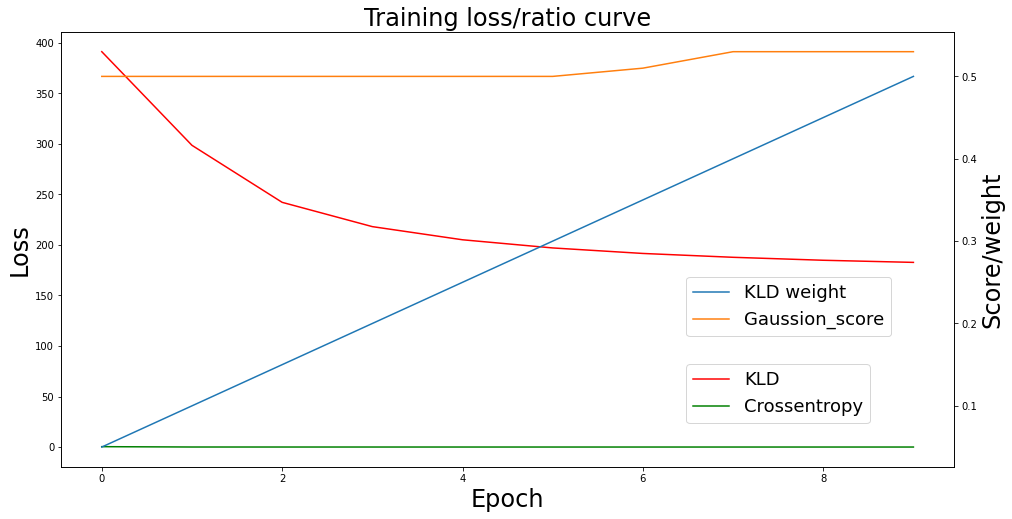

In [11]:
#Plot result


fig, ax1 = plt.subplots(figsize=(16,8))

plt.title("Training loss/ratio curve",fontsize=24) 
ax1.set_ylabel("Loss",fontsize=24) 
plt.xlabel("Epoch",fontsize=24)
ax1.plot(range(10),KLD_cost_list,color="red")
ax1.plot(range(10),crossentropy,color="green")

ax2 = ax1.twinx()
ax2.set_ylabel("Score/weight",fontsize=24) 
ax2.plot(range(10),KLD_weight_list)
ax2.plot(range(10),gaussion_score)
ax1.legend(["KLD","Crossentropy"], loc= {0.7,0.1},fontsize=18)
ax2.legend(["KLD weight","Gaussion_score"], loc={0.7,0.3},fontsize=18)
# plt.savefig('./generation.jpg',dpi=300)
plt.show()

In [13]:
#Save model

# torch.save(encoder1, './encoder_generation.pt')
# torch.save(decoder1, './decoder_generation.pt')

In [5]:
#Load model and predict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder1=torch.load('encoder_generation.pt').to(device)
decoder1=torch.load('decoder_generation.pt').to(device)
result=evaluate(encoder1,decoder1)
print(result)
print("Gaussion score : ",Gaussian_score(result))

[['abandon', 'abandons', 'abandoning', 'abandoned'], ['abet', 'abets', 'abeting', 'abeted'], ['abdicate', 'abdicates', 'abdicateing', 'abdicateed'], ['abduct', 'abducts', 'abducting', 'abducted'], ['abound', 'abounds', 'abounding', 'abounded'], ['absorb', 'absorbs', 'absorbing', 'absorbed'], ['accept', 'accepts', 'accepting', 'accepted'], ['accompany', 'accompanys', 'accompanying', 'accompanyed'], ['accomplish', 'accomplishs', 'accomplishing', 'accomplished'], ['account', 'accounts', 'accounting', 'accounted'], ['accuse', 'accuses', 'accuseing', 'accuseed'], ['ache', 'aches', 'acheing', 'acheed'], ['achieve', 'achieves', 'achieveing', 'achieveed'], ['acknowledge', 'acknowledges', 'acknowledgeing', 'acknowledgeed'], ['acsosuire', 'acnuires', 'acnuireing', 'aceuireed'], ['abstract', 'abstracts', 'abstracting', 'abstracted'], ['add', 'adds', 'adding', 'added'], ['address', 'addresss', 'addressing', 'addressed'], ['adjoin', 'adjoins', 'adjoining', 'adjoined'], ['adjourn', 'adjourns', 'adjo